In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from ba_datasets import LogMelDataset, load_dataset
from models import XVector
from tools import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
dataset, label_vocab, label_to_idx, idx_to_label = load_dataset("dataset_slim.pt")
xvector_model = XVector(
    feat_dim=80,
    d_model=256,
    nhead=4,
    nlayers=3,
    emb_dim=256,
    num_classes=len(label_vocab),
)
xvector_model.load_ckpt("xvector_easy.pth")

In [3]:
def collate_fn(batch):
    from torch.nn.utils.rnn import pad_sequence

    logmel, labels = zip(*batch)
    lengths = torch.tensor([f.size(0) for f in logmel])
    feats_padded = pad_sequence([*logmel], batch_first=True)  # (B,T,F)
    labels = torch.tensor([label_to_idx[l] for l in labels], dtype=torch.long)
    return feats_padded, labels, lengths


from tqdm.auto import tqdm
import pandas as pd

xvector_model.to(device)

with torch.no_grad():
    xvector_model.eval()
    loader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collate_fn)
    embs = []
    for batch in tqdm(loader):
        logmel, labels, lengths = batch
        logmel, lengths = logmel.to(device), lengths.to(device)
        logits, emb = xvector_model(logmel, lengths)
        embs.extend(
            [
                {
                    "label": idx_to_label[l.item()],
                    "emb": e.cpu().numpy(),
                }
                for e, l in zip(emb, labels)
            ]
        )
    df_embs = pd.DataFrame(embs)

  0%|          | 0/1216 [00:00<?, ?it/s]

In [4]:
centroids = []
for label, group in df_embs.groupby("label"):
    centroid = np.mean(np.stack(group["emb"].to_list()), axis=0)
    centroids.append(
        {
            "label": label,
            "emb": centroid,
        }
    )
df_centroids = pd.DataFrame(centroids)
df_centroids.to_parquet("xvector_centroids.parquet")

In [3]:
import os
from transformers import HubertModel, Wav2Vec2FeatureExtractor

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

hubert_name = "facebook/hubert-large-ls960-ft"
hubert = HubertModel.from_pretrained(hubert_name).eval().to(device).requires_grad_(False)  # type: ignore
hubert_fe = Wav2Vec2FeatureExtractor.from_pretrained(hubert_name)
hubert_sr = 16000

In [4]:
from glob import glob
import torchaudio


def to_16ms(x, target_length):
    # scale time dimension by 1.25 (50 Hz -> 62.5 Hz)
    x_up = F.interpolate(
        x.transpose(-1, -2),
        scale_factor=(target_length + 1) / x.shape[-2],
        mode="linear",
        align_corners=False,
    )[:, :, :target_length]
    return x_up.transpose(-1, -2)


def prepare_wav(wav, sr):
    wav = wav.to(device)
    if wav.ndim > 1:
        wav = torch.mean(wav, dim=0, keepdim=True)  # to mono
    if sr != hubert_sr:
        wav = torchaudio.functional.resample(wav, sr, hubert_sr)
        sr = hubert_sr
    logmel = to_logmelspec(wav, sr)
    f0 = extract_f0_torchcrepe(wav)
    # plt.plot(f0.cpu().numpy()[0])

    # HuBERT runs at ~20ms stride; we’ll resample to 16ms by linear interpolation later
    inputs = hubert_fe(
        wav.cpu().numpy(), sampling_rate=hubert_sr, return_tensors="pt", padding=True
    )
    with torch.no_grad():
        out = hubert(inputs.input_values.to(device))  # last hidden state (B,T_h,D)
        H = out.last_hidden_state.squeeze(0)

    H = to_16ms(H.unsqueeze(0), f0.shape[-1]).squeeze(0)  # (T_h,D)
    H, f0, logmel = H.cpu(), f0.cpu(), logmel.cpu()
    return H, f0, logmel


audio_files = sorted(glob("VOC_JP/**/*.ogg", recursive=True))
audio_labels = [os.path.basename(os.path.dirname(f)) for f in audio_files]
wav, sr = torchaudio.load(audio_files[0])
H, f0, logmel = prepare_wav(wav, sr)
print(H.shape, f0.shape, logmel.shape)
print(H.device, f0.device, logmel.device)

/home/lyc/work/ba_voice/.venv/lib/python3.13/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/lyc/work/ba_voice/.venv/lib/python3.13/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

torch.Size([114, 1024]) torch.Size([1, 114]) torch.Size([1, 114, 80])
cpu cpu cpu


In [5]:
import joblib
from torch.utils.data import Dataset

from models import Content2MelAttn

centroids = pd.read_parquet("xvector_centroids.parquet")
centroids_dict = {x["label"]: x["emb"] for x in centroids.to_dict("records")}


class VCSet(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels
        self.cache = {}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        if i in self.cache:
            return self.cache[i]

        path, spk = self.files[i], self.labels[i]
        wav, sr = torchaudio.load(path)
        wav = wav.to(device)
        wav = wav.mean(0, keepdim=True)  # to mono
        if sr != 16000:
            wav = torchaudio.functional.resample(wav, sr, 16000)
            sr = 16000
        spk = torch.tensor(centroids_dict[spk])
        x = wav
        H, f0, mel = prepare_wav(x, sr)  # (T,1024),(T,),(T,80)
        f0, mel = f0.squeeze(0), mel.squeeze(0)
        # print(H.shape, f0.shape, mel.shape, spk.shape)
        """
        torch.Size([145, 1024]) torch.Size([1, 145]) torch.Size([1, 145, 80]) torch.Size([256])
        torch.Size([1042, 1024]) torch.Size([1, 1042]) torch.Size([1, 1042, 80]) torch.Size([256])
        """
        self.cache[i] = (H, f0, mel, spk)
        return self.cache[i]

    def warmup(self):
        from tqdm.auto import tqdm

        for i in tqdm(range(len(self))):
            self[i]


from torch.nn.utils.rnn import pad_sequence


def vc_collate(batch):
    Hs, f0s, mels, spks = zip(*batch)
    L = torch.tensor([m.size(0) for m in mels], dtype=torch.long)

    # pad_sequence expects a list of (T, D) tensors → returns (T_max, B, D)
    H_pad = pad_sequence([*Hs], batch_first=True)  # (B, Tm, 768)
    f0_pad = pad_sequence([*f0s], batch_first=True)
    mel_pad = pad_sequence([*mels], batch_first=True)  # (B, Tm, 80)

    # speaker vectors (condition)
    V = torch.stack(spks)  # (B, 256)

    return H_pad, f0_pad, mel_pad, V, L


audio_files = sorted(glob("VOC_JP/**/*.ogg", recursive=True))
audio_labels = [os.path.basename(os.path.dirname(p)) for p in audio_files]
dataset = VCSet(audio_files, audio_labels)

if os.path.exists("vc_dataset_cache.joblib"):
    dataset = joblib.load("vc_dataset_cache.joblib")
else:
    dataset.warmup()
    joblib.dump(dataset, "vc_dataset_cache.joblib")

In [6]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    collate_fn=vc_collate,
    shuffle=True,
)
torch.cuda.empty_cache()

In [13]:
import torch
from tqdm.auto import tqdm

torch.cuda.empty_cache()
# model_vc = Content2Mel(
#     content_dim=1024,
#     spk_dim=256,
#     hid=2048,
#     n_mels=80,
#     n_blocks=12,
# ).to(device)
model_vc = Content2MelAttn(
    content_dim=1024,
    spk_dim=256,
    d_model=512,
    nhead=8,
    nlayers=16,
    ff_mult=8,
    n_mels=80,
    dropout=0.1,
).to(device)
if os.path.exists("content2mel_selfrec.pt"):
    model_vc.load_state_dict(torch.load("content2mel_selfrec.pt"))


def masked_l1(pred, tgt, L):
    B, T, _ = pred.size()
    mask = (
        (torch.arange(T, device=pred.device)[None, :] < L[:, None])
        .float()
        .unsqueeze(-1)
    )
    return ((pred - tgt).abs() * mask).sum() / mask.sum().clamp_min(1.0)


from torch.utils.tensorboard import SummaryWriter
from transformers import SpeechT5HifiGan

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
vocoder.eval().to(device).requires_grad_(False)  # type: ignore
xvector_model.eval().to(device).requires_grad_(False)

XVector(
  (proj): Linear(in_features=80, out_features=256, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (pos): PosEnc()
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    

In [14]:
opt = torch.optim.AdamW(model_vc.parameters(), lr=3e-4, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=100, eta_min=1e-5)
writer = SummaryWriter()
global_step = 0

In [ ]:
import random
import torch
from collections import deque
for ep in (mb := tqdm(range(100))):
    model_vc.train()
    tot = n = 0
    for H, f0, mel, V, L in (pb := tqdm(dataloader, leave=False)):
        H, f0, mel, V, L = (
            H.to(device),
            f0.to(device),
            mel.to(device),
            V.to(device),
            L.to(device),
        )
        pred = model_vc(H, f0, V)
        # print(H.shape, f0.shape, mel.shape, V.shape, pred.shape)
        # raise
        loss_1 = masked_l1(pred, mel, L)

        new_idx = [*range(len(V))]
        random.shuffle(new_idx)
        V = V[new_idx]
        pred2 = model_vc(H, f0, V)
        # loss_2 = F.l1_loss(V, xvector_model(pred2, L)[1])
        loss_2 = 1 - F.cosine_similarity(V, xvector_model(pred2, L)[1], dim=-1).mean()

        wav2 = vocoder(pred2)
        # hubert_feats = hubert_fe(
        #     wav2,
        #     sampling_rate=hubert_sr,
        #     return_tensors="pt",
        #     padding=True,
        # )
        out = hubert(wav2)  # last hidden state (B,T_h,D)
        H2 = out.last_hidden_state
        # H2 = to_16ms(H2.unsqueeze(0), f0.shape[-1]).squeeze(0)  # (T_h,D)
        H2_lst = []
        for b in range(H2.size(0)):
            H2_lst.append(to_16ms(H2[b].unsqueeze(0), H.size(1)).squeeze(0))
        H2 = torch.stack(H2_lst, dim=0)

        loss_3 = masked_l1(H2, H, L) / H.size(0)

        loss = loss_1 + loss_2 + loss_3

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_vc.parameters(), 5.0)
        opt.step()
        tot += loss.item() * H.size(0)
        n += H.size(0)
        pb.set_postfix(loss1=loss_1.item(), loss2=loss_2.item(), loss3=loss_3.item())
        writer.add_scalar("train/loss1", loss_1.item(), global_step)
        writer.add_scalar("train/loss2", loss_2.item(), global_step)
        writer.add_scalar("train/loss3", loss_3.item(), global_step)
        global_step += 1
        if global_step % 100 == 0:
            torch.save(model_vc.state_dict(), "content2mel_selfrec.pt")
    sched.step()
    # print(f"[ep {ep+1}] L1mel {tot/n:.4f}")
    mb.set_postfix_str(f"L1mel {tot/n:.4f}")
    torch.save(model_vc.state_dict(), "content2mel_selfrec.pt")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/9726 [00:00<?, ?it/s]

In [ ]:
# model_vc.load_state_dict(torch.load("content2mel_selfrec.pt", map_location=device))
model_vc.eval()

def convert_voice(wav_path: str, target_spk: str):
    wav, sr = torchaudio.load(wav_path)
    wav = torch.mean(wav, dim=0, keepdim=True)  # to mono
    if sr != 16000:
        wav = torchaudio.functional.resample(wav, sr, 16000)
    sr = 16000

    H, f0, _ = prepare_wav(wav, sr)  # we won't use source mel here
    V = centroids_dict[target_spk]  # your centroid, (256,)
    V = torch.tensor(np.array(V))
    print(H.shape, f0.shape, V.shape)
    with torch.no_grad():
        pred_mel = model_vc(
            H.unsqueeze(0).to(device),
            f0.to(device),
            V.unsqueeze(0).to(device),
        )[
            0
        ]  # (T,80)
        y = vocoder(pred_mel.unsqueeze(0)).squeeze(0).cpu().numpy()
    return y, pred_mel.cpu()

VOC_JP/JP_Airi/airi_cafe_act_1.ogg -> JP_CH0273


/home/lyc/work/ba_voice/.venv/lib/python3.13/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/lyc/work/ba_voice/.venv/lib/python3.13/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

torch.Size([203, 1024]) torch.Size([1, 203]) torch.Size([256])
torch.Size([203, 1024]) torch.Size([1, 203]) torch.Size([256])


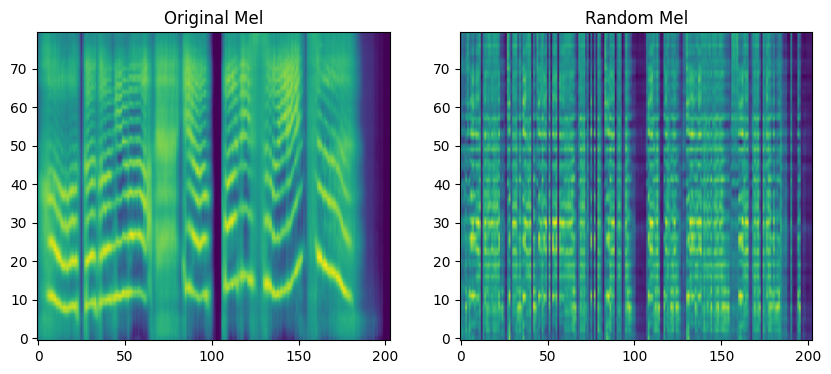

In [28]:
sorted(audio_files)
audio_labels[0]
import random

idx = 1
rnd = random.randint(0, len(audio_files) - 1)
print(audio_files[idx], "->", audio_labels[rnd])
y, mel = convert_voice(audio_files[idx], audio_labels[idx])
y2, mel2 = convert_voice(audio_files[idx], audio_labels[rnd])
# plt.imshow(mel.transpose(0, 1), aspect="auto", origin="lower")
# plt.imshow(mel2.transpose(0, 1), aspect="auto", origin="lower")
# plot mel and mel2 together
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(mel.transpose(0, 1), aspect="auto", origin="lower")
plt.title("Original Mel")
plt.subplot(1, 2, 2)
plt.imshow(mel2.transpose(0, 1), aspect="auto", origin="lower")
plt.title("Random Mel")
plt.show()

display_audio(y, 16000)
display_audio(y2, 16000)